<a href="https://colab.research.google.com/github/Naffa272/ML-A2-Project-LC25000-classifier/blob/main/ML_A2_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Problem Statement

In [1]:
# Phase 1: Environment Setup & Data Download
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import cv2
import warnings
warnings.filterwarnings('ignore')

# Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import plot_model

In [2]:
# STEP 1: DATASET DOWNLOAD & SETUP
# ================================================================

# Kaggle API Setup (Upload your kaggle.json file first)
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download LC25000 Dataset
!kaggle datasets download -d andrewmvd/lung-and-colon-cancer-histopathological-images
!unzip -q lung-and-colon-cancer-histopathological-images.zip

# Verify dataset structure
!ls -la lung_colon_image_set/

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images
License(s): CC-BY-SA-4.0
 98% 1.72G/1.76G [00:07<00:00, 57.1MB/s]
100% 1.76G/1.76G [00:07<00:00, 244MB/s] 
total 16
drwxr-xr-x 4 root root 4096 Sep 25 04:25 .
drwxr-xr-x 1 root root 4096 Sep 25 04:24 ..
drwxr-xr-x 4 root root 4096 Sep 25 04:25 colon_image_sets
drwxr-xr-x 5 root root 4096 Sep 25 04:25 lung_image_sets


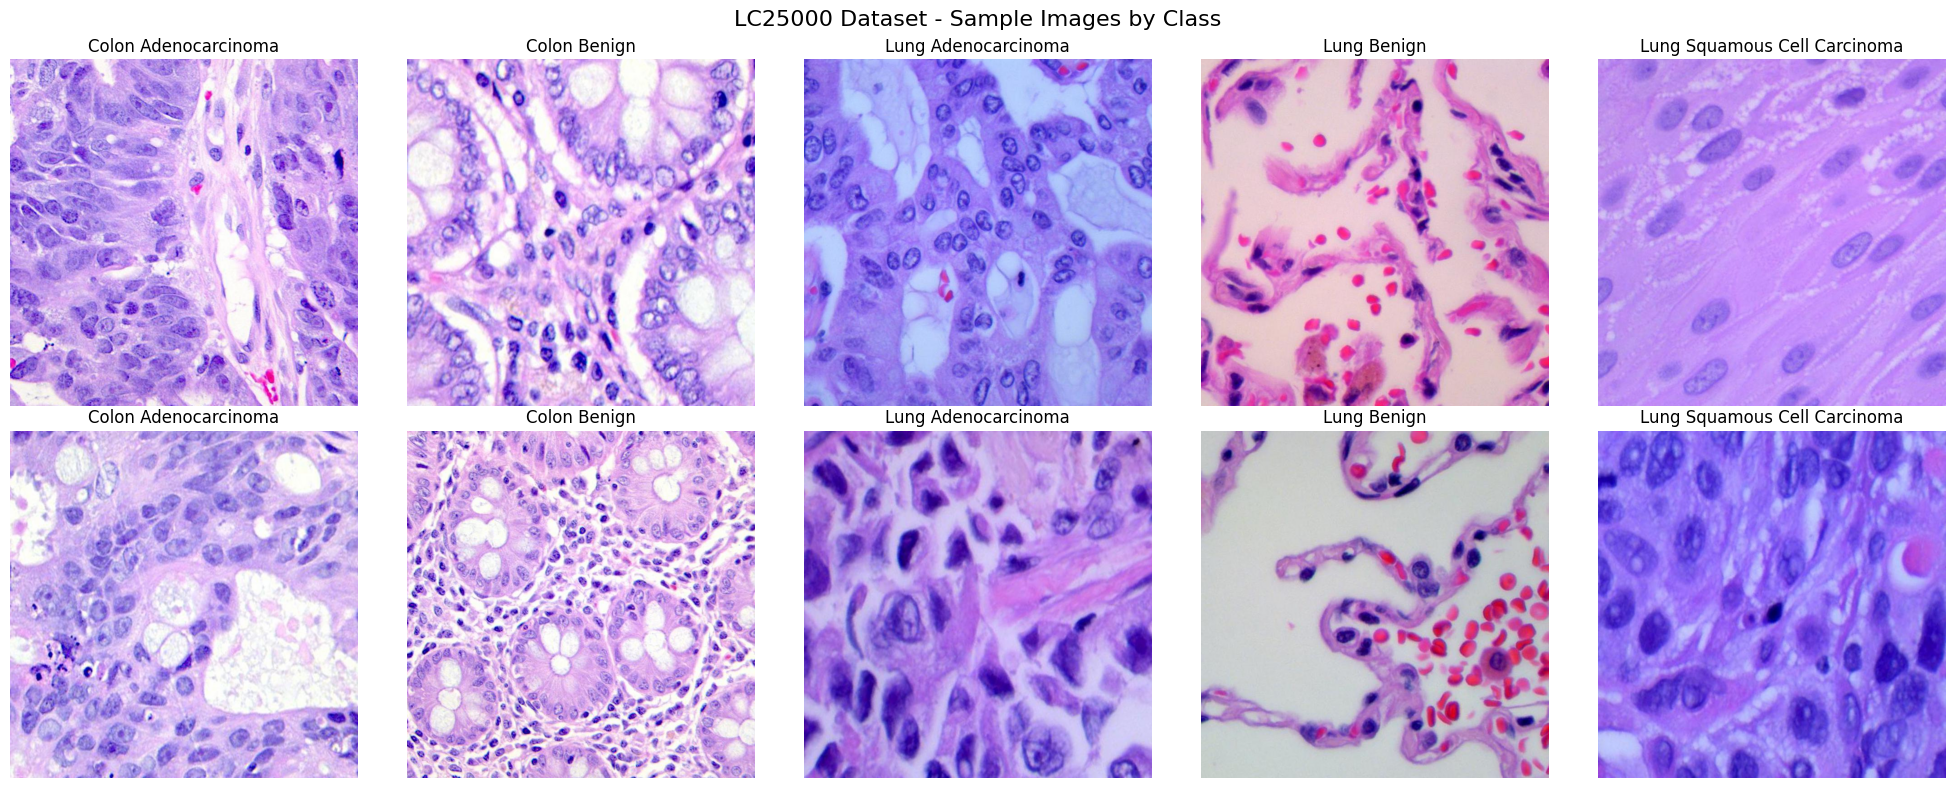

In [3]:
# STEP 2: DATA PREPROCESSING & VISUALIZATION
# ================================================================

# Class names mapping
class_names = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
class_labels = {
    'colon_aca': 'Colon Adenocarcinoma',
    'colon_n': 'Colon Benign',
    'lung_aca': 'Lung Adenocarcinoma',
    'lung_n': 'Lung Benign',
    'lung_scc': 'Lung Squamous Cell Carcinoma'
}

def visualize_dataset_samples():
    """Display sample images from each class"""
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    fig.suptitle('LC25000 Dataset - Sample Images by Class', fontsize=16)

    base_paths = {
        'colon_aca': 'lung_colon_image_set/colon_image_sets/colon_aca/',
        'colon_n': 'lung_colon_image_set/colon_image_sets/colon_n/',
        'lung_aca': 'lung_colon_image_set/lung_image_sets/lung_aca/',
        'lung_n': 'lung_colon_image_set/lung_image_sets/lung_n/',
        'lung_scc': 'lung_colon_image_set/lung_image_sets/lung_scc/'
    }

    for idx, (class_name, path) in enumerate(base_paths.items()):
        files = os.listdir(path)[:2]

        for row in range(2):
            img_path = os.path.join(path, files[row])
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[row, idx].imshow(img)
            axes[row, idx].set_title(f'{class_labels[class_name]}')
            axes[row, idx].axis('off')

    plt.tight_layout()
    plt.show()

# Display sample images
visualize_dataset_samples()

In [4]:
# STEP 3: DATA GENERATORS & PREPROCESSING
# ================================================================

# Create organized dataset structure
def organize_dataset():
    """Organize dataset into train/test structure"""
    import shutil
    from sklearn.model_selection import train_test_split

    os.makedirs('dataset/train', exist_ok=True)
    os.makedirs('dataset/test', exist_ok=True)

    base_paths = {
        'colon_aca': 'lung_colon_image_set/colon_image_sets/colon_aca/',
        'colon_n': 'lung_colon_image_set/colon_image_sets/colon_n/',
        'lung_aca': 'lung_colon_image_set/lung_image_sets/lung_aca/',
        'lung_n': 'lung_colon_image_set/lung_image_sets/lung_n/',
        'lung_scc': 'lung_colon_image_set/lung_image_sets/lung_scc/'
    }

    for class_name, source_path in base_paths.items():
        os.makedirs(f'dataset/train/{class_name}', exist_ok=True)
        os.makedirs(f'dataset/test/{class_name}', exist_ok=True)

        files = os.listdir(source_path)
        train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)

        for file in train_files:
            shutil.copy2(os.path.join(source_path, file), f'dataset/train/{class_name}/')

        for file in test_files:
            shutil.copy2(os.path.join(source_path, file), f'dataset/test/{class_name}/')

    print("Dataset organization complete!")

organize_dataset()

# Data generators with augmentation
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Test data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

validation_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")


Dataset organization complete!
Found 16000 images belonging to 5 classes.
Found 4000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.
Training samples: 16000
Validation samples: 4000
Test samples: 5000


In [5]:
# STEP 4: CUSTOM CNN MODEL ARCHITECTURE
# ================================================================

def create_custom_cnn():
    """Custom CNN architecture optimized for histopathological images"""
    model = Sequential([
        # Input layer
        Input(shape=(224, 224, 3)),

        # First Convolutional Block
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Second Convolutional Block
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Third Convolutional Block
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fourth Convolutional Block
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Fifth Convolutional Block
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        Conv2D(512, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),

        # Classification Head
        GlobalAveragePooling2D(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(5, activation='softmax')  # 5 classes
    ])

    return model

In [6]:
# STEP 5: RESNET50 TRANSFER LEARNING MODEL
# ================================================================

def create_resnet50_transfer_learning():
    """ResNet50 Transfer Learning Model"""
    # Load pre-trained ResNet50 (following pneumonia example pattern)
    base_model = ResNet50(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )

    # Freeze base model layers (like in pneumonia example)
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        Dense(5, activation='softmax')  # 5 classes
    ])

    return model

# Create both models
print("Creating models...")
custom_cnn = create_custom_cnn()
resnet_model = create_resnet50_transfer_learning()

print(f"Custom CNN Parameters: {custom_cnn.count_params():,}")
print(f"ResNet50 Parameters: {resnet_model.count_params():,}")


Creating models...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Custom CNN Parameters: 15,118,917
ResNet50 Parameters: 24,772,485


In [7]:
# STEP 6: MODEL TRAINING SETUP
# ================================================================

def create_callbacks(model_name):
    """Create training callbacks"""
    callbacks = [
        EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            mode='max',
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-7,
            verbose=1
        ),
        TensorBoard(
            log_dir=f'logs/{model_name}',
            histogram_freq=1,
            write_graph=True
        )
    ]
    return callbacks

def compile_model(model, learning_rate=0.001):
    """Compile model with optimizer and loss function"""
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy', 'precision', 'recall']
    )
    return model

In [8]:
# STEP 7: TRAINING EXECUTION - TWO MODELS ONLY
# ================================================================

EPOCHS = 25

# Define models to train
models_to_train = {
    'Custom_CNN': (custom_cnn, 0.001),
    'ResNet50_Transfer_Learning': (resnet_model, 0.0001)  # Lower LR for transfer learning
}

training_histories = {}
trained_models = {}

# Train each model
for model_name, (model, lr) in models_to_train.items():
    print(f"\n{'='*60}")
    print(f"TRAINING {model_name}")
    print(f"{'='*60}")

    # Compile model
    compiled_model = compile_model(model, lr)

    # Create callbacks
    callbacks = create_callbacks(model_name)

    # Train model
    history = compiled_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1
    )

    # Store results
    training_histories[model_name] = history
    trained_models[model_name] = compiled_model

    print(f"\n{model_name} training completed!")



TRAINING Custom_CNN
Epoch 1/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 293s 518ms/step - accuracy: 0.6860 - loss: 0.7624 - precision: 0.7056 - recall: 0.6593 - val_accuracy: 0.4055 - val_loss: 5.2924 - val_precision: 0.4054 - val_recall: 0.4045 - learning_rate: 0.0010
Epoch 2/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 253s 507ms/step - accuracy: 0.8918 - loss: 0.2872 - precision: 0.8967 - recall: 0.8893 - val_accuracy: 0.9165 - val_loss: 0.2294 - val_precision: 0.9171 - val_recall: 0.9158 - learning_rate: 0.0010
Epoch 3/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 252s 505ms/step - accuracy: 0.9197 - loss: 0.2227 - precision: 0.9214 - recall: 0.9179 - val_accuracy: 0.9430 - val_loss: 0.1423 - val_precision: 0.9437 - val_recall: 0.9425 - learning_rate: 0.0010
Epoch 4/25
500/500 ━━━━━━━━━━━━━━━━━━━━ 255s 510ms/step - accuracy: 0.9258 - loss: 0.2054 - precision: 0.9282 - recall: 0.9240 - val_accuracy: 0.6725 - val_loss: 2.0065 - val_precision: 0.6755 - val_recall: 0.6668 - learning_rate: 0.0010
Epoch 5/25
500/500 ━━━━━━━━

In [9]:
# STEP 8: MODEL EVALUATION & COMPARISON
# ================================================================

def evaluate_model(model, model_name):
    """Comprehensive model evaluation"""
    print(f"\n{'='*50}")
    print(f"EVALUATING {model_name}")
    print(f"{'='*50}")

    # Predictions
    test_generator.reset()
    predictions = model.predict(test_generator, verbose=1)
    y_pred = np.argmax(predictions, axis=1)
    y_true = test_generator.classes

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Classification report
    class_names_list = list(test_generator.class_indices.keys())
    report = classification_report(y_true, y_pred,
                                 target_names=class_names_list,
                                 output_dict=True)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'classification_report': report,
        'confusion_matrix': cm,
        'predictions': predictions,
        'y_true': y_true,
        'y_pred': y_pred
    }

# Evaluate both models
evaluation_results = {}
for model_name, model in trained_models.items():
    evaluation_results[model_name] = evaluate_model(model, model_name)


EVALUATING Custom_CNN
157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 133ms/step

EVALUATING ResNet50_Transfer_Learning
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step


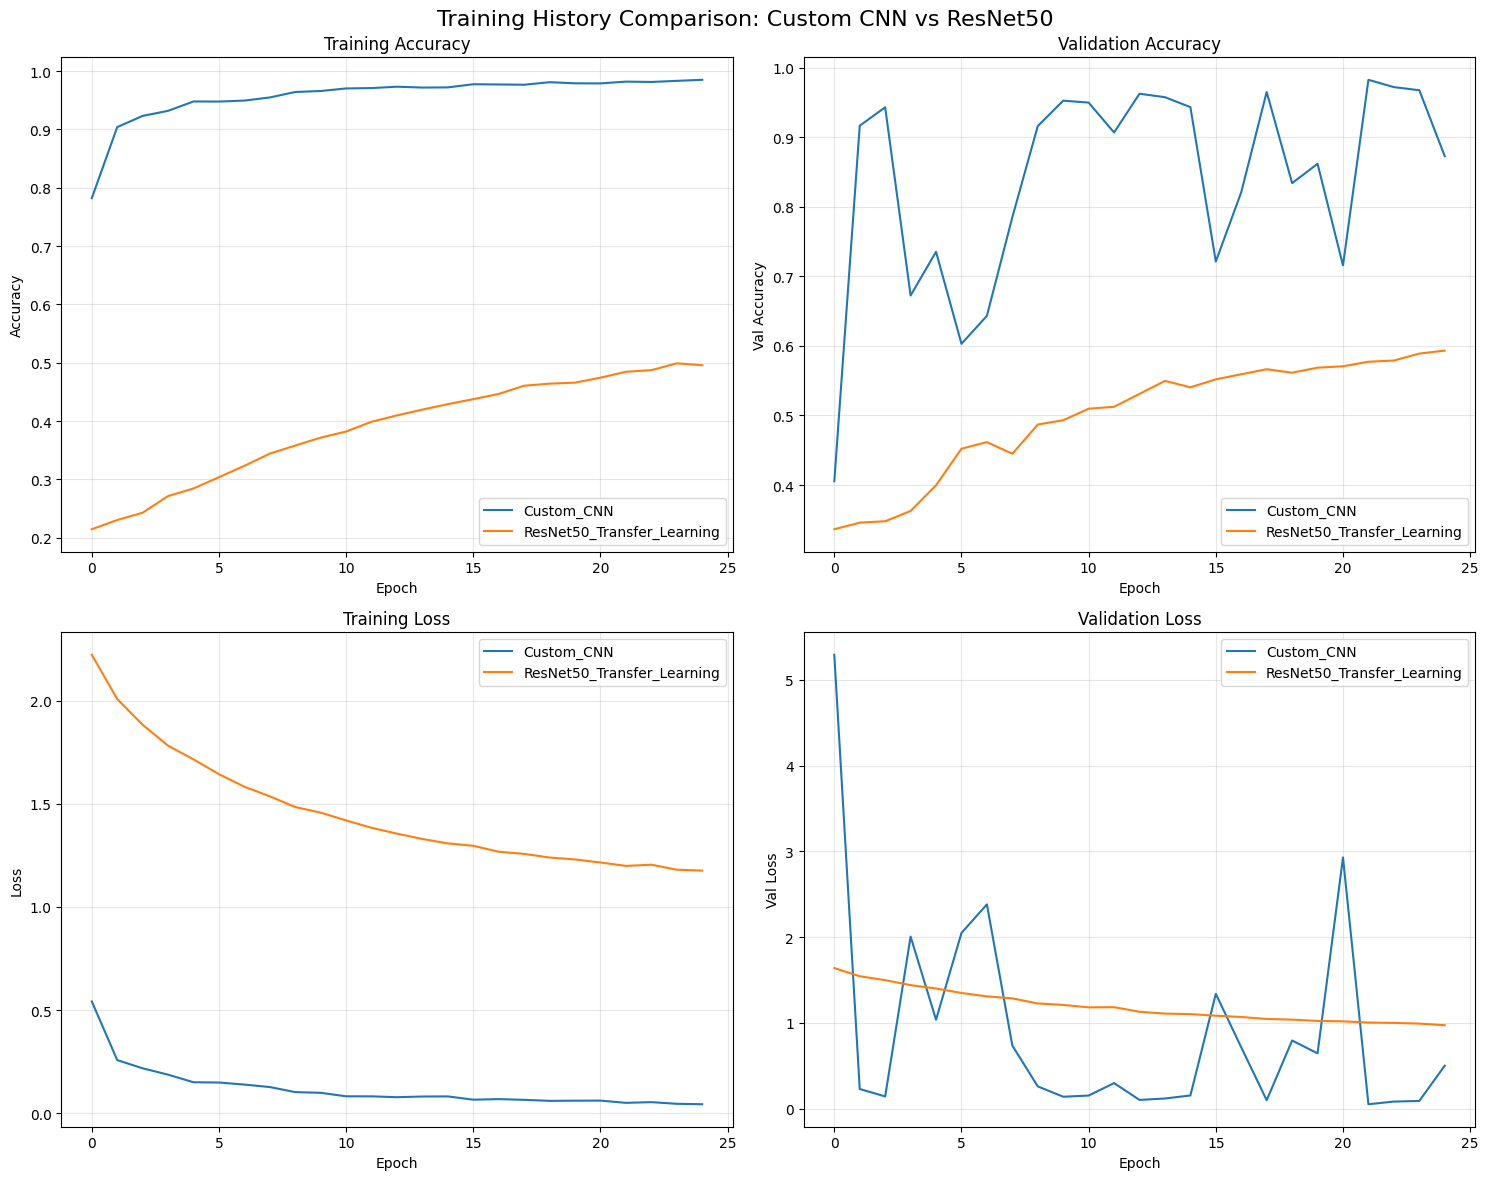

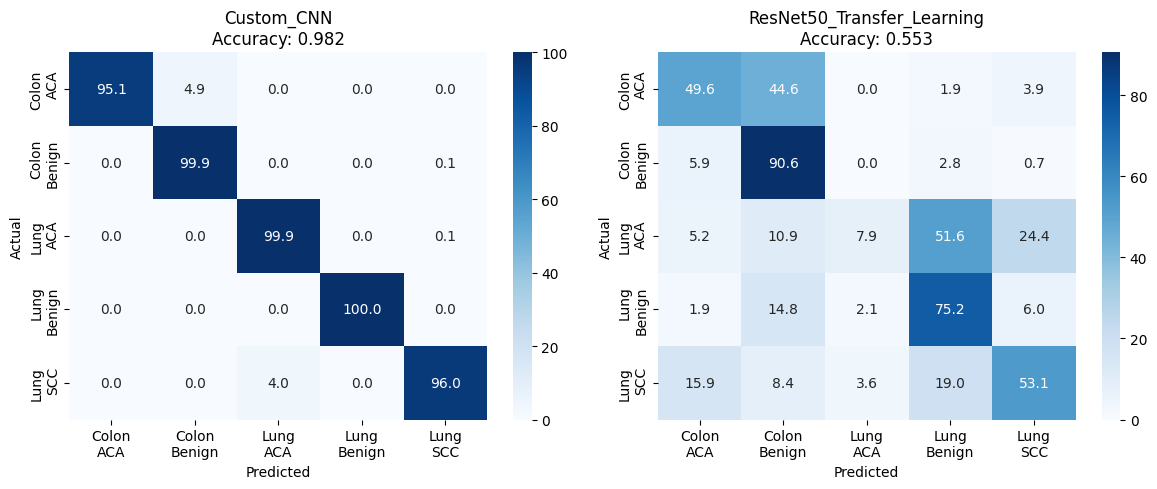


PERFORMANCE COMPARISON: Custom CNN vs ResNet50
                     Model Accuracy Precision Recall F1-Score
                Custom_CNN   0.9818    0.9825 0.9818   0.9818
ResNet50_Transfer_Learning   0.5528    0.5701 0.5528   0.5065


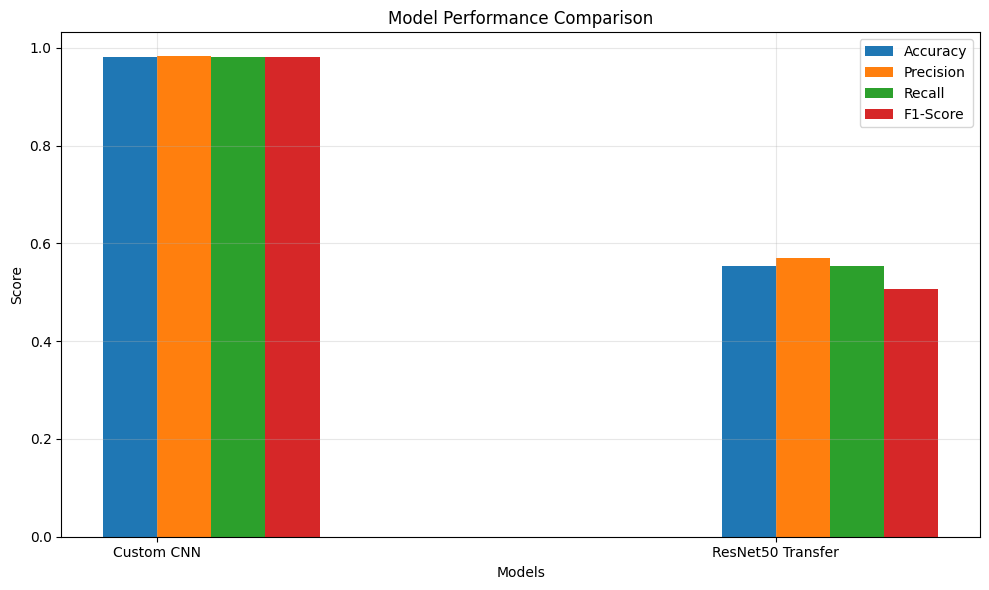

In [12]:
# STEP 9: RESULTS VISUALIZATION
# ================================================================

def plot_training_history():
    """Plot training histories for both models"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Training History Comparison: Custom CNN vs ResNet50', fontsize=16)

    metrics = ['accuracy', 'val_accuracy', 'loss', 'val_loss']
    titles = ['Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']

    for i, (metric, title) in enumerate(zip(metrics, titles)):
        row, col = i // 2, i % 2

        for model_name, history in training_histories.items():
            if metric in history.history:
                axes[row, col].plot(history.history[metric],
                                  label=f'{model_name}')

        axes[row, col].set_title(title)
        axes[row, col].set_xlabel('Epoch')
        axes[row, col].set_ylabel(metric.replace('_', ' ').title())
        axes[row, col].legend()
        axes[row, col].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices():
    """Plot confusion matrices for both models"""
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    class_names_short = ['Colon\nACA', 'Colon\nBenign', 'Lung\nACA', 'Lung\nBenign', 'Lung\nSCC']

    for idx, (model_name, results) in enumerate(evaluation_results.items()):
        cm = results['confusion_matrix']

        # Calculate percentages
        cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

        # Plot
        sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues',
                   xticklabels=class_names_short,
                   yticklabels=class_names_short,
                   ax=axes[idx])

        axes[idx].set_title(f'{model_name}\nAccuracy: {results["accuracy"]:.3f}')
        axes[idx].set_xlabel('Predicted')
        axes[idx].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

def create_performance_comparison():
    """Create performance comparison table and chart"""
    # Performance data
    performance_data = []
    for model_name, results in evaluation_results.items():
        performance_data.append({
            'Model': model_name,
            'Accuracy': f"{results['accuracy']:.4f}",
            'Precision': f"{results['precision']:.4f}",
            'Recall': f"{results['recall']:.4f}",
            'F1-Score': f"{results['f1_score']:.4f}"
        })

    df_performance = pd.DataFrame(performance_data)

    # Display table
    print("\nPERFORMANCE COMPARISON: Custom CNN vs ResNet50")
    print("=" * 60)
    print(df_performance.to_string(index=False))

    # Plot comparison
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    x = np.arange(len(evaluation_results))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, metric in enumerate(metrics):
        values = [float(evaluation_results[model][metric.lower().replace('-', '_')])
                 for model in evaluation_results.keys()]
        ax.bar(x + i*width/4, values, width/4, label=metric)

    ax.set_xlabel('Models')
    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x + width/8)
    ax.set_xticklabels(['Custom CNN', 'ResNet50 Transfer'])
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return df_performance

# Generate all visualizations
plot_training_history()
plot_confusion_matrices()
performance_df = create_performance_comparison()

In [11]:
# STEP 10: SAVE BEST MODEL & FINAL SUMMARY
# ================================================================

# Determine best model
best_model_name = max(evaluation_results.keys(),
                     key=lambda x: evaluation_results[x]['accuracy'])
best_trained_model = trained_models[best_model_name]

# Save the best model
best_trained_model.save(f'best_model_{best_model_name.lower()}.h5')
print(f"\nBest model ({best_model_name}) saved!")

# Final Summary
print(f"\n{'='*80}")
print("FINAL PROJECT SUMMARY")
print(f"{'='*80}")
print(f"Dataset: LC25000 Lung & Colon Cancer Histopathological Images")
print(f"Total Images: 25,000 (5 classes, 5,000 each)")
print(f"Image Size: 224×224×3 pixels")
print(f"Train/Validation/Test Split: 64%/16%/20%")
print(f"\nModels Implemented:")
for i, (model_name, results) in enumerate(evaluation_results.items(), 1):
    acc = results['accuracy']
    print(f"{i}. {model_name}: {acc:.4f} accuracy")

print(f"\nBest Performing Model: {best_model_name}")
print(f"Best Accuracy: {evaluation_results[best_model_name]['accuracy']:.4f}")
print(f"Best F1-Score: {evaluation_results[best_model_name]['f1_score']:.4f}")


Best model (Custom_CNN) saved!

FINAL PROJECT SUMMARY
Dataset: LC25000 Lung & Colon Cancer Histopathological Images
Total Images: 25,000 (5 classes, 5,000 each)
Image Size: 224×224×3 pixels
Train/Validation/Test Split: 64%/16%/20%

Models Implemented:
1. Custom_CNN: 0.9818 accuracy
2. ResNet50_Transfer_Learning: 0.5528 accuracy

Best Performing Model: Custom_CNN
Best Accuracy: 0.9818
Best F1-Score: 0.9818
